# Multi-layer Perceptron

[Andrej Karpathy LLM Tutorial pt 2](https://www.youtube.com/watch?v=TCH_1BHY58I)

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 09/10/2025   | Martin | Create  |  | 

# Content

* [Introduction](#introduction)
* [Setup](#setup)

In [ ]:
%load_ext watermark

# Introduction

The original bag-of-words model and count frequency model fails because as the context length (in this case the number of characters used to predict the next character) increases, the matrix becomes intractable for computation.

Learning is also limited due to the number of tunable parameters in the system, making relationships harder to model.

The solution is as follows:
- Project inputs (characters, words, etc.) to a representative lower dimensional space
- Increase the number of paramters to capture more complex relationships

# Setup

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open("data/names.txt", "r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [ ]:
# Building the vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {v: k+1 for k, v in enumerate(chars)}
stoi['.'] = 0
itos = {v: k for k, v in stoi.items()}

In [42]:
# Build the dataset
block_size = 3 # context length
X, Y = [], []
for w in words:
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(f"{''.join([itos[i] for i in context])} ---> {itos[ix]}")
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [43]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

# Model

Convert the 27 letters into a 2 dimensional representation. Then pass it through 2 layers, with the output layer being a 27 dimension vector representing the letters

In [44]:
C = torch.randn((27, 2)) # second number is the embedding dimensions space
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [45]:
# Assuming the first layer has 100 neurons
W1 = torch.randn((6, 100)) # 6 because if the embedding space is 2 and the block_size is 3, for each entry there are 6 inputs
b1 = torch.randn(100)
W.shape

torch.Size([6, 100])

The embedding input space is incompatible with the number of neurons. So, we reshape the tensor using `.view()` to make it fit

In [24]:
m = emb.view(-1, 6) @ W + b
h = torch.tanh(m)

In [25]:
# Second layer
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [26]:
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

This is the current probability distribution based on the training data. To get the loss, we index the target letters from this distribution and compute the negative log-likelihood.

In [28]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(14.3843)

In [35]:
# Use the cross entropy function in torch to simplify the above cells to get loss
loss = F.cross_entropy(logits, Y)
loss

tensor(14.3843)

Putting it together

In [68]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

Total number of parameters: 3481


In [69]:
# Setting a custom learning rate picker
# Iterates through a list of decreasing learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [70]:
lri = []
lossi = []

for i in range(1000):

  ix = torch.randint(0, X.shape[0], (32, )) # minibatch

  # Forward pass
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix])

  # Backwards pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad
  
  # Append stats
  lri.append(lre[i])
  lossi.append(loss.item())

print(loss.item())

11.618349075317383


Text(0.5, 1.0, 'Learning Rate Exponent vs. Loss')

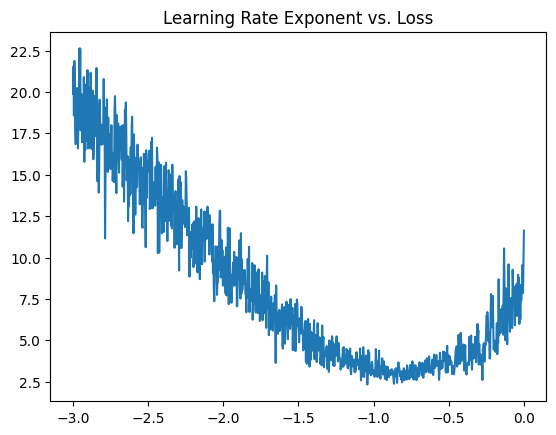

In [72]:
plt.plot(lri, lossi)
plt.title("Learning Rate Exponent vs. Loss")

We observe that the smallest loss value occurs when the exponentiated learning rate is approximately -1, therefore a good learning rate would be-0.1. This is found by selecting the lowest point of the loss curve

In [ ]:
%watermark

Last updated: 2025-10-09T21:41:28.059052+08:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 9.3.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 24.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit



: 